# Predicting Customer Lifetime Value through Behavioral Segmentation

## Problem Statement

The objective is to create a classification model that predicts Customer Lifetime Value (CLV) for new customers based on their initial purchase behavior, purchase frequency, and engagement metrics. This model will classify customers into segments such as 'High-Valued' and 'Low-Valued' which will enhance targeted marketing strategies.

### About the Dataset

- **Source**: [Online Retail Dataset](https://archive.ics.uci.edu/dataset/352/online+retail)
- This dataset contains all transactions from December 1, 2010, to December 9, 2011, for a UK-based online retailer specializing in unique gifts. Many customers are wholesalers.

### Dataset Information

| Variable Name | Type       | Description                                 |
|---------------|------------|---------------------------------------------|
| InvoiceNo     | Categorical| A unique 6-digit number for each transaction. If it starts with 'c', it indicates a cancellation. |
| StockCode     | Categorical| A unique 5-digit number for each product.  |
| Description   | Categorical| The name of the product.                    |
| Quantity      | Integer    | The quantity of each product per transaction.|
| InvoiceDate   | Date       | The date and time of each transaction.     |
| UnitPrice     | Continuous | The price per unit (in sterling).          |
| CustomerID    | Categorical| A unique 5-digit number for each customer. |
| Country       | Categorical| The country where the customer resides.    |

### Key Concepts

- **CLTV**: Customer Lifetime Value is calculated using the formula:  
  $$ CLTV = \left(\frac{\text{Average Order Value} \times \text{Purchase Frequency}}{\text{Churn Rate}}\right) \times \text{Profit Margin} $$

- **Customer Value**:  
  $$ \text{Customer Value} = \text{Average Order Value} \times \text{Purchase Frequency} $$

- **Average Order Value (AOV)**:  
  $$ \text{AOV} = \frac{\text{Total Revenue}}{\text{Total Number of Orders}} $$  
  (AOV indicates the average amount spent per order.)

- **Purchase Frequency (PF)**:  
  $$ \text{PF} = \frac{\text{Total Number of Orders}}{\text{Total Number of Customers}} $$  
  (PF reflects the average number of orders per customer.)

- **Customer Lifetime**:  
  $$ \text{Customer Lifetime} = \frac{1}{\text{Churn Rate}} $$  
  (This measures how long a customer continues to make purchases.)

- **Churn Rate**:  
  $$ \text{Churn Rate} = 1 - \text{Repeat Rate} $$  
  (The repeat rate is the proportion of customers with more than one order compared to the total number of unique customers.)


## Data Pre-Processing

### Importing Necessary Libraries

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from ydata_profiling import ProfileReport
%matplotlib inline

In [59]:
# Set seaborn color codes
sns.set(color_codes=True)

### Loading the dataset

In [60]:
df = pd.read_csv('OnlineRetail.csv',encoding='ISO-8859-1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


### Generate Profile Report

In [61]:
profile=ProfileReport(df,title='Online Retail Report')
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [62]:
# Getting info on the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


### Checking for Null Values

In [63]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

### Dropping duplicate data & filtering

In [64]:
# Filter unique customer and country data
filtered_data=df[['Country','CustomerID']].drop_duplicates()

In [65]:
filtered_data

,Country,CustomerID
0,United Kingdom,17850.0
9,United Kingdom,13047.0
26,France,12583.0
46,United Kingdom,13748.0
65,United Kingdom,15100.0
...,...,...
536969,United Kingdom,13436.0
537255,United Kingdom,15520.0
538064,United Kingdom,13298.0
538812,United Kingdom,14569.0


### Plotting top ten countries by customer count

<Axes: xlabel='Country'>

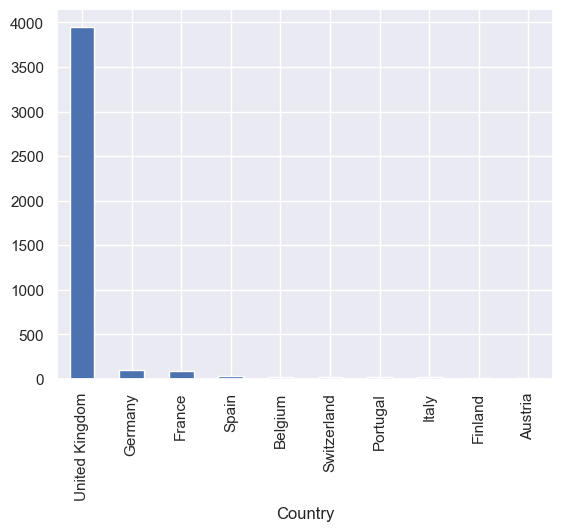

In [66]:
# Top ten country's customer
filtered_data.Country.value_counts()[:10].plot(kind='bar')

From the above plot we can see that UK has the highest customers (~90%) as compared to other countries

In [67]:
# Filter data for UK customers as they have the highest count
uk_df=df[df.Country=='United Kingdom']
uk_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 495478 entries, 0 to 541893
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    495478 non-null  object 
 1   StockCode    495478 non-null  object 
 2   Description  494024 non-null  object 
 3   Quantity     495478 non-null  int64  
 4   InvoiceDate  495478 non-null  object 
 5   UnitPrice    495478 non-null  float64
 6   CustomerID   361878 non-null  float64
 7   Country      495478 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 34.0+ MB


In [68]:
#Shape of UK data
uk_df.shape

(495478, 8)

In [69]:
# Description of UK data
uk_df.describe()

,Quantity,UnitPrice,CustomerID
count,495478.000000,495478.000000,361878.000000
mean,8.605486,4.532422,15547.871368
std,227.588756,99.315438,1594.402590
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,14194.000000
50%,3.000000,2.100000,15514.000000
75%,10.000000,4.130000,16931.000000
max,80995.000000,38970.000000,18287.000000


From the above description we can see that some customers have ordered in negative quantity which is not possible \
Hence filtering quantity greater than zero

In [70]:
# Filter out negative quantities
uk_df = uk_df[(uk_df['Quantity']>0)]
uk_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 486286 entries, 0 to 541893
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    486286 non-null  object 
 1   StockCode    486286 non-null  object 
 2   Description  485694 non-null  object 
 3   Quantity     486286 non-null  int64  
 4   InvoiceDate  486286 non-null  object 
 5   UnitPrice    486286 non-null  float64
 6   CustomerID   354345 non-null  float64
 7   Country      486286 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.4+ MB


## Feature Engineering

### Filter significant columns

In [71]:
uk_df=uk_df[['CustomerID','InvoiceDate','InvoiceNo','Quantity','UnitPrice']]

### Adding new feature TotalPurchase

In [72]:
#Calulate total purchase amount per customer
uk_df['TotalPurchase'] = uk_df['Quantity']*uk_df['UnitPrice']

In [73]:
uk_df.head()

,CustomerID,InvoiceDate,InvoiceNo,Quantity,UnitPrice,TotalPurchase
0,17850.0,12/1/2010 8:26,536365,6,2.55,15.30
1,17850.0,12/1/2010 8:26,536365,6,3.39,20.34
2,17850.0,12/1/2010 8:26,536365,8,2.75,22.00
3,17850.0,12/1/2010 8:26,536365,6,3.39,20.34
4,17850.0,12/1/2010 8:26,536365,6,3.39,20.34


In [74]:
# Changing invoice date to datetime format for clarity
uk_df['InvoiceDate'] = pd.to_datetime(uk_df['InvoiceDate'], errors='coerce')

In [75]:
#Define a recency date for calculation
day="2012-01-01"
day=pd.to_datetime(day)

In [76]:
# Aggregate data to create RFM features
rfm = uk_df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (day-x.max()).days,  # Recency
    'InvoiceNo': 'count',  # Frequency
    'TotalPurchase': 'sum'    # Monetary
}).reset_index()
rfm.head()

,CustomerID,InvoiceDate,InvoiceNo,TotalPurchase
0,12346.0,347,1,77183.60
1,12747.0,24,103,4196.01
2,12748.0,22,4596,33719.73
3,12749.0,25,199,4090.88
4,12820.0,25,59,942.34


#### *Note* :
- **Recency (R):** Recency measures how recently a customer has made a purchase.
- **Frequency (F):** Frequency measures how often a customer makes a purchase within a given time period.
- **Monetary Value (M):** Monetary measures how much money a customer spends on purchases over a specified period.

### Renaming columns

In [77]:
rfm.columns=['CustomerID','Recency','Frequency','Monetary']

In [78]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,347,1,77183.60
1,12747.0,24,103,4196.01
2,12748.0,22,4596,33719.73
3,12749.0,25,199,4090.88
4,12820.0,25,59,942.34


### Defining Target variable

In [79]:
rfm = rfm[rfm['Monetary'] > 0]

In [80]:
threshold = 500  # Define your threshold for high value
rfm['CLV_Segment'] = rfm['Monetary'].apply(lambda x: 'High Value' if x > threshold else 'Average Value')


### Label Encoding for categorical variables

In [81]:
from sklearn.preprocessing import LabelEncoder
# Label Encoding for CLV_Segment
le = LabelEncoder()
rfm['CLV_Segment'] = le.fit_transform(rfm['CLV_Segment'])

In [82]:
rfm.head() 

,CustomerID,Recency,Frequency,Monetary,CLV_Segment
0,12346.0,347,1,77183.60,1
1,12747.0,24,103,4196.01,1
2,12748.0,22,4596,33719.73,1
3,12749.0,25,199,4090.88,1
4,12820.0,25,59,942.34,1


In [83]:
# Therefore showing the CLV_Segment = 1 for high valued customer and CLV_Segment = 0 for low valued customer
result=rfm.CLV_Segment.value_counts()
result

CLV_Segment
1    2273
0    1647
Name: count, dtype: int64

### Distribution of Customer Value Segments

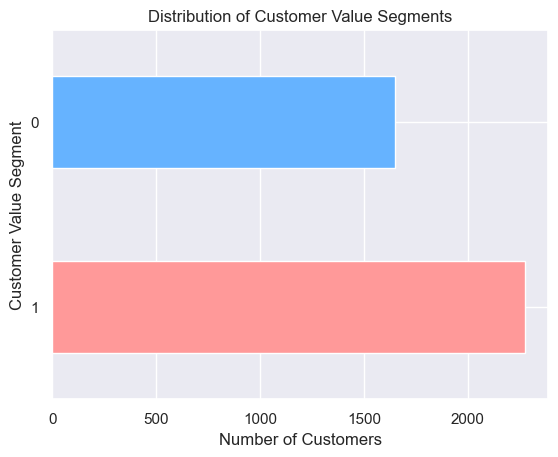

In [84]:
colors = ["#FF9999", "#66B3FF"]

result.plot(kind="barh", color=colors)
plt.xlabel('Number of Customers')
plt.ylabel('Customer Value Segment')
plt.title('Distribution of Customer Value Segments')
plt.show()


In [85]:
# checking if any null values still left
rfm.isnull().sum()

CustomerID     0
Recency        0
Frequency      0
Monetary       0
CLV_Segment    0
dtype: int64

## Model Training and Evaluation

In [86]:
X = rfm[['Recency', 'Frequency', 'Monetary']]
y = rfm['CLV_Segment']

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Using K-Nearest Neighbours

In [88]:
knn=KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train,y_train)

KNeighborsClassifier()

In [89]:
y_pred=knn.predict(X_test)

In [90]:
y_pred

array([1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,

### Confusion Matrix for KNN

In [91]:
print(confusion_matrix(y_test,y_pred))

[[348   1]
 [  1 434]]


### KNN Accuracy Score

In [92]:
acc_knn=round(accuracy_score(y_test,y_pred)*100,2)
print(acc_knn)

99.74


### KNN Precision Score

In [93]:
print(precision_score(y_test,y_pred))

0.9977011494252873


### KNN Recall Score

In [94]:
print(recall_score(y_test,y_pred))

0.9977011494252873


### KNN F1 Score

In [95]:
f1= f1_score(y_test,y_pred)
print(f"F1 Score is :{f1}")

F1 Score is :0.9977011494252873


### Logistic Regression

In [96]:
#logistic regression
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression()
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)
acc_logreg=round(accuracy_score(y_pred,y_test)*100,2)
print(acc_logreg)

99.62


#### Using a test case for the model choosing random forest:

In [97]:
# Input features for the model
test_data = pd.DataFrame({
    'Recency': [30],
    'Frequency': [5],
    'Monetary': [700]
})

In [98]:
# Assuming the trained model is named 'rf' for Random Forest
predicted_segment = logreg.predict(test_data)

In [99]:
predicted_segment

array([1])

### Decision Tree

In [100]:
#decision tree
from sklearn.tree import DecisionTreeClassifier
dtree=DecisionTreeClassifier()
dtree.fit(X_train,y_train)
y_pred=dtree.predict(X_test)
acc_dtree=round(accuracy_score(y_pred,y_test)*100,2)
print(acc_dtree)

99.87


#### Using a test case for the model choosing Decision Tree:

In [101]:
# Input features for the model
test_data = pd.DataFrame({
    'Recency': [30],
    'Frequency': [5],
    'Monetary': [700]
})

In [102]:
# Assuming the trained model is named 'rf' for Random Forest
predicted_segment = dtree.predict(test_data)

In [103]:
predicted_segment

array([1])

### Random Forest

In [104]:
#random forest
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(n_estimators= 800,
 min_samples_split= 10,
 min_samples_leaf= 4,
 max_features= 'sqrt',
 max_depth= 50,
 bootstrap= True)
rf.fit(X_train,y_train)
y_pred=rf.predict(X_test)
acc_rf=round(accuracy_score(y_pred,y_test)*100,2)
print(acc_rf)

99.87


#### Using a test case for the model choosing random forest:

In [105]:
# Input features for the model
test_data = pd.DataFrame({
    'Recency': [30],
    'Frequency': [5],
    'Monetary': [700]
})

In [106]:
# Assuming the trained model is named 'rf' for Random Forest
predicted_segment = rf.predict(test_data)

In [107]:
predicted_segment

array([1])

### Naive Bayes

In [108]:
#naive bayes
from sklearn.naive_bayes import GaussianNB
nb=GaussianNB()
nb.fit(X_train,y_train)
y_pred=nb.predict(X_test)
acc_nb=round(accuracy_score(y_pred,y_test)*100,2)
print(acc_nb)

89.41


#### Using a test case for the model choosing Naive Bayes:

In [109]:
# Input features for the model
test_data = pd.DataFrame({
    'Recency': [30],
    'Frequency': [5],
    'Monetary': [700]
})

In [110]:
# Assuming the trained model is named 'rf' for Random Forest
predicted_segment = rf.predict(test_data)

In [111]:
predicted_segment

array([1])

### All accuracy scores in one frame

In [112]:
models=pd.DataFrame({
    'Model':['KNN','Logistic Regression','Decision Tree','Random Forest','Naive Bayes'],
    'Score':[acc_knn,acc_logreg,acc_dtree,acc_rf,acc_nb]
})
models.sort_values(by='Score',ascending=False)

,Model,Score
2,Decision Tree,99.87
3,Random Forest,99.87
0,KNN,99.74
1,Logistic Regression,99.62
4,Naive Bayes,89.41


In [113]:
# Calculate precision scores for each model
prec_knn = round(precision_score(y_test, knn.predict(X_test)) * 100, 2)
prec_logreg = round(precision_score(y_test, logreg.predict(X_test)) * 100, 2)
prec_dtree = round(precision_score(y_test, dtree.predict(X_test)) * 100, 2)
prec_rf = round(precision_score(y_test, rf.predict(X_test)) * 100, 2)
prec_nb = round(precision_score(y_test, nb.predict(X_test)) * 100, 2)

# Create a DataFrame to compare precision scores
models_prec = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'Naive Bayes'],
    'Precision': [prec_knn, prec_logreg, prec_dtree, prec_rf, prec_nb]
})

# Display the results
print(models_prec.sort_values(by='Precision', ascending=False))


                 Model  Precision
2        Decision Tree     100.00
3        Random Forest     100.00
0                  KNN      99.77
1  Logistic Regression      99.77
4          Naive Bayes      97.06


### AUC-ROC Curve Plotting

In [114]:
from sklearn.metrics import roc_curve, auc

In [116]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)

Text(0.5, 0, 'False Positive Rate')

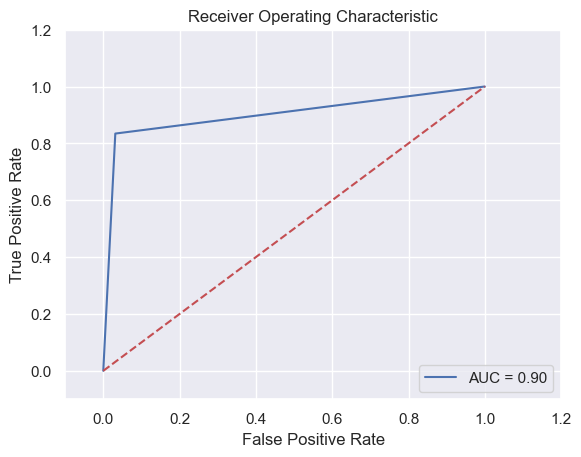

In [117]:
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

### Insights on the AUC-ROC Curve:
- AUC Score: 0.90 indicates excellent performance in distinguishing between high-value and low-value customers.
- Model Interpretation:
    - *True Positive Rate (TPR):* High proportion of correctly identified high-value customers.
    - *False Positive Rate (FPR):* Low proportion of incorrectly identified low-value customers.
- Performance Relative to Random Guessing: Curve significantly above the diagonal line (AUC = 0.5), showing much better performance than random predictions.

## Conclusion

The project effectively predicted Customer Lifetime Value (CLV) through behavioral segmentation, leading to several key insights:

- **Data Analysis**: Utilized customer metrics—recency, frequency, and monetary value—for predictions.
- **Model Evaluation**: Random Forest was the top-performing model, achieving an AUC of 0.90, indicating strong differentiation between high-value and low-value customers.
- **Targeted Marketing Insights**: The model helps businesses identify high-value customers with greater spending and engagement, enhancing marketing strategies and resource allocation.
- **Future Recommendations**: Focus on optimizing classification thresholds, analyzing feature importance, and implementing cross-validation for improved model robustness.